# American Community Survey (ACS)

In [1]:
import pdb
import random
from imp import reload

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import SVG, display

from acs import ACSCountyReader, read_merge_acs
from map_maker import draw_county_data_svg
from probplots import plot_dists_pps

pd.set_option('display.float_format', lambda x: '%.3f' % x)

%matplotlib inline

SEED = 42
random.seed(SEED)

sns.set_context('talk')


In [2]:
DATA_DIR    = '../Data/'
IMG_DIR     = '../Images/'
DEM_DIR     = ''.join([DATA_DIR, 'Demography/'])

SVG_FP = ''.join([IMG_DIR, 'temp.svg'])  # for exploring

POP_FP           = ''.join([DEM_DIR, 'ACS_15_5YR_B01003/',
                            'ACS_15_5YR_B01003_with_ann.csv'])
FOREIGN_BIRTH_FP = ''.join([DEM_DIR, 'ACS_15_5YR_B05006/', 
                                'ACS_15_5YR_B05006_with_ann.csv'])
SNGL_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04004/',
                            'ACS_15_5YR_B04004_with_ann.csv'])
MULT_ANCE_FP     = ''.join([DEM_DIR, 'ACS_15_5YR_B04005/',
                           'ACS_15_5YR_B04005_with_ann.csv'])
ALL_ANCE_FP      = ''.join([DEM_DIR, 'ACS_15_5YR_B04006/',
                            'ACS_15_5YR_B04006_with_ann.csv'])


In [3]:
acs_reader = ACSCountyReader(POP_FP)
acs_pop = acs_reader.read_counties()
acs_pop.head()

In [4]:
params = [
    dict(name='Born_Isr', kw='Israel', fp=FOREIGN_BIRTH_FP),
    dict(name='Only_Isr', kw='Israel', fp=SNGL_ANCE_FP),
    dict(name='Part_Isr', kw='Israel', fp=MULT_ANCE_FP),
    ]
    
df = read_merge_acs(params)
df.head()

,Born_Isr,Only_Isr,Part_Isr
FIPS,,,
01007,0,0,7
01015,16,16,0
01045,0,0,9
01055,15,0,0
01073,32,5,174


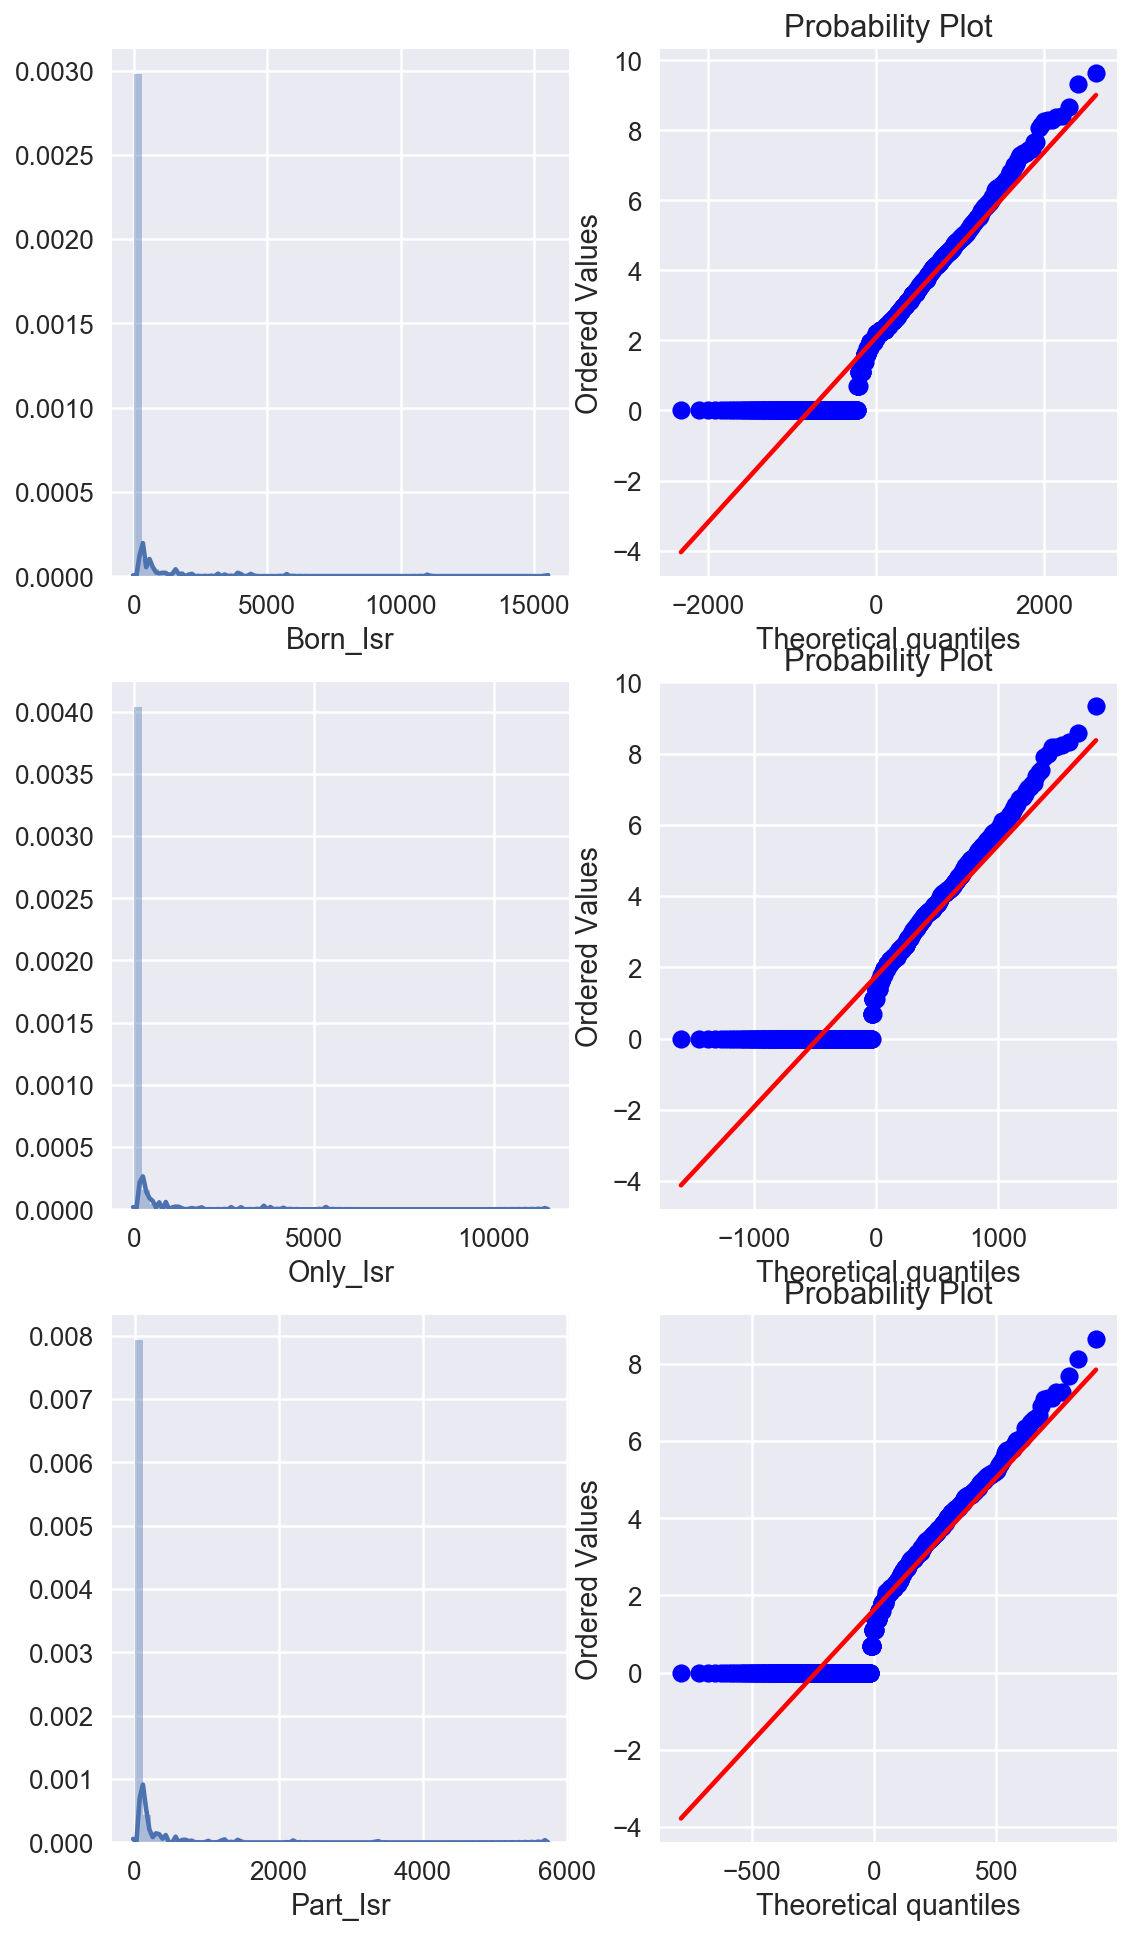

In [5]:
plot_dists_pps(df)

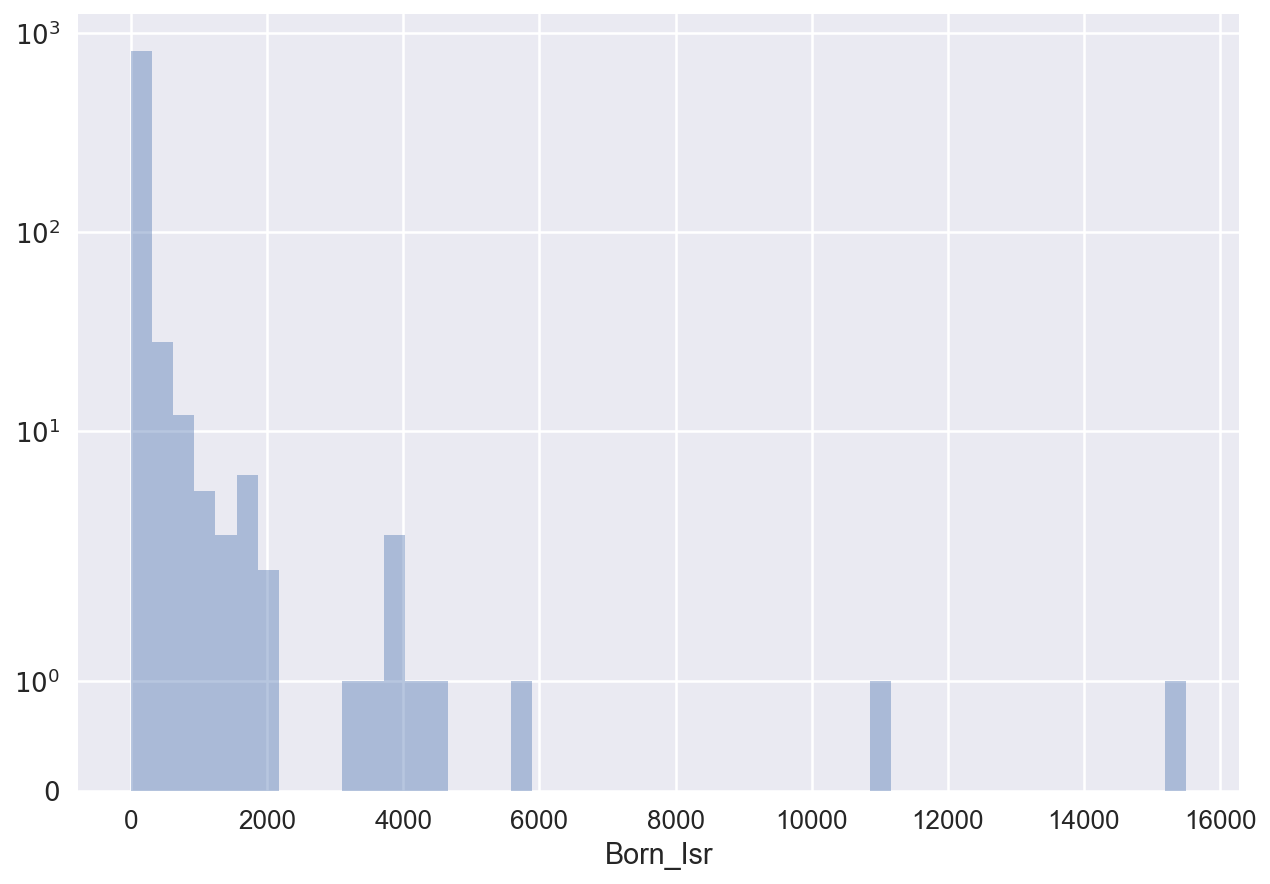

In [6]:
sns.distplot(df.Born_Isr, kde=False)
plt.yscale('symlog')